In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import joblib

ModuleNotFoundError: No module named 'pandas'

In [5]:
X_train_scaled = joblib.load("../data/processed/X_train_scaled.pkl")
X_test_scaled = joblib.load("../data/processed/X_test_scaled.pkl")
X_train = joblib.load("../data/processed/X_train.pkl")
y_train = joblib.load("../data/processed/y_train.pkl")
X_test = joblib.load("../data/processed/X_test.pkl")
y_test = joblib.load("../data/processed/y_test.pkl")

Linear Regression is used as a baseline model. Since linear models are sensitive to feature scaling, we apply StandardScaler within a Pipeline.

In [13]:
linear_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("linear", LinearRegression())
])

The model is trained on log-transformed target values.

In [14]:
linear_pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('linear', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None


Performance metrics are first evaluated on the log-transformed target.

In [15]:
y_pred_lir_log = linear_pipeline.predict(X_test)

print("Train R2 (log):", linear_pipeline.score(X_train, y_train))
print("Test R2 (log):", linear_pipeline.score(X_test, y_test))
print("R2 (log):", r2_score(y_test, y_pred_lir_log))
print("MAE (log):", mean_absolute_error(y_test, y_pred_lir_log))
print("RMSE (log):", np.sqrt(mean_squared_error(y_test, y_pred_lir_log)))

Train R2 (log): 0.8757381763959102
Test R2 (log): 0.8742700955616357
R2 (log): 0.8742700955616357
MAE (log): 0.13754316787260246
RMSE (log): 0.18930634757940065


Predictions are converted back using expm1 to interpret errors in real price units.

In [ ]:
y_pred_lir_no_log = np.expm1(y_pred_lir_log)
y_true_lir_no_log = np.expm1(y_test)

print("R2 (real):", r2_score(y_true_lir_no_log, y_pred_lir_no_log))
print("MAE (real price):", mean_absolute_error(y_true_lir_no_log, y_pred_lir_no_log))
print("RMSE (real price):", np.sqrt(mean_squared_error(y_true_lir_no_log, y_pred_lir_no_log)))

R2 (real): 0.6497599896508421
MAE (real price): 82164.53813254193
RMSE (real price): 230104.61374208285



Since Linear Regression is a fully interpretable model, coefficients indicate:

- Direction of impact (positive/negative)
- Strength of influence on house price

Features with larger absolute coefficients have stronger effects.

In [17]:
coefficients = pd.Series(
    linear_pipeline.named_steps["linear"].coef_,
    index=X_train.columns
).sort_values(key=abs, ascending=False)

coefficients.head(10)

sqft_living      0.155519
grade            0.115770
zipcode_98004    0.106653
zipcode_98103    0.092850
zipcode_98115    0.091248
zipcode_98112    0.090527
zipcode_98117    0.087315
lat              0.078374
zipcode_98033    0.077653
zipcode_98040    0.075287
dtype: float64

Residual plots help assess:

- Linearity assumption
- Homoscedasticity
- Presence of systematic bias

A random scatter around zero indicates good model fit.

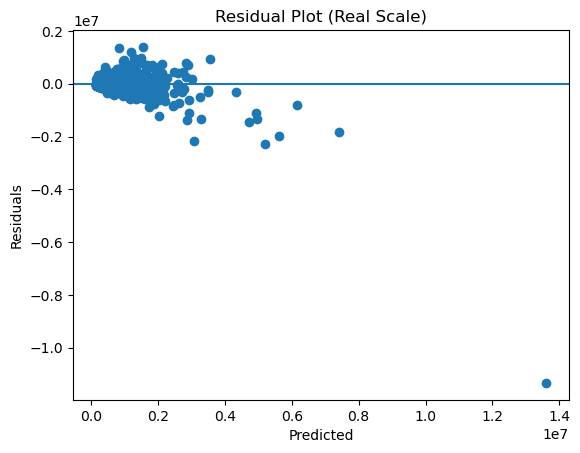

In [18]:
residuals = y_true_lir_no_log - y_pred_lir_no_log

plt.scatter(y_pred_lir_no_log, residuals)
plt.axhline(0)
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot (Real Scale)")
plt.show()

Ridge Regression is used to reduce overfitting by adding L2 regularization. Since Ridge is sensitive to feature scaling, we use a Pipeline that includes:

- StandardScaler
- RidgeCV for automatic alpha tuning

In [30]:
ridge_Pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("ridge", RidgeCV(alphas=np.logspace(-3, 3, 50), cv=5))
])

The model is trained using 5-fold cross-validation to automatically select the optimal regularization strength (alpha).

In [31]:
ridge_Pipeline.fit(X_train, y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('ridge', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"alphas alphas: array-like of shape (n_alphas,), default=(0.1, 1.0, 10.0)Array of alpha values to try.Regularization strength; must be a positive float. Regularizationimproves the conditioning of the problem and reduces the variance ofthe estimates. Larger values specify stronger regularization.Alpha corresponds to ``1 / (2C)`` in other linear models such as:class:`~sklearn.linear_model.LogisticRegression` or:class:`~sklearn.svm.LinearSVC`.If using Leave-One-Out cross-validation, alphas must be strictly positive.",array([1.0000...00000000e+03])
,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto false, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"scoring scoring: str, callable, default=NoneThe scoring method to use for cross-validation. Options:- str: see :ref:`scoring_string_names` for options.- callable: a scorer callable object (e.g., function) with signature ``scorer(estimator, X, y)``. See :ref:`scoring_callable` for details.- `None`: negative :ref:`mean squared error ` if cv is None (i.e. when using leave-one-out cross-validation), or :ref:`coefficient of determination ` (:math:`R^2`) otherwise.",None
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the efficient Leave-One-Out cross-validation- integer, to specify the number of folds.- :term:`CV splitter`,- An iterable yield

Cross-validation selects the alpha value that maximizes validation R².

In [32]:
best_alpha = ridge_Pipeline.named_steps["ridge"].alpha_
print("Best alpha:", best_alpha)

Best alpha: 0.655128556859551


The Ridge model demonstrates stable generalization with a small gap between training and test performance.Regularization helps control variance while maintaining predictive power.

In [33]:
y_pred_ridge_log = ridge_Pipeline.predict(X_test)

print("Train R2:", ridge_Pipeline.score(X_train, y_train))
print("Test R2:", ridge_Pipeline.score(X_test, y_test))
print("R2", r2_score(y_test, y_pred_ridge_log))
print("MAE:", mean_absolute_error(y_test, y_pred_ridge_log))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_ridge_log)))

Train R2: 0.8757380297806576
Test R2: 0.8742686649875573
R2 0.8742686649875573
MAE: 0.13754536399736408
RMSE: 0.18930742455462218


Since the target variable was log-transformed using log1p, predictions are converted back using expm1. This allows interpretation of errors in real currency values.

In [34]:
y_pred_ridge_no_log = np.expm1(y_pred_ridge_log)
y_true_ridge_no_log = np.expm1(y_test)

print("R2 (real):", r2_score(y_true_ridge_no_log, y_pred_ridge_no_log))
print("MAE (real price):", mean_absolute_error(y_true_ridge_no_log, y_pred_ridge_no_log))
print("RMSE (real price):", np.sqrt(mean_squared_error(y_true_ridge_no_log, y_pred_ridge_no_log)))

R2 (real): 0.6498656877232147
MAE (real price): 82163.52617947296
RMSE (real price): 230069.88976900032


We use Random Forest as a bagging-based ensemble method to capture non-linear patterns in the dataset. The baseline model is initialized with default parameters.

In [24]:
rf = RandomForestRegressor(random_state=42)

We define a search space to tune the parameters. RandomizedSearchCV is used for efficient exploration.

In [25]:
param_dist = {
    "n_estimators": np.arange(100, 800, 100),
    "max_depth": [None] + list(np.arange(5, 40, 5)),
    "min_samples_split": np.arange(2, 15),
    "min_samples_leaf": np.arange(1, 10),
    "max_features": ["sqrt", "log2", None]
}

We perform Randomized Search with:

- 40 random combinations
- 5-fold cross-validation
- R² as evaluation metric

This helps reduce overfitting while finding optimal model complexity.

In [26]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=40,              
    cv=5,
    scoring="r2",
    verbose=2,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits
[CV] END max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  46.4s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  50.2s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  51.6s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  55.9s
[CV] END max_depth=30, max_features=log2, min_samples_leaf=3, min_samples_split=9, n_estimators=400; total time=  56.3s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=   8.4s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=100; total time=   7.1s
[CV] END max_depth=10, max_features=sqrt, min_samples_leaf=6, min_samples_split=5, n_estimators=10

,"estimator estimator: estimator objectAn object of that type is instantiated for each grid point.This is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",RandomForestR...ndom_state=42)
,"param_distributions param_distributions: dict or list of dictsDictionary with parameters names (`str`) as keys and distributionsor lists of parameters to try. Distributions must provide a ``rvs``method for sampling (such as those from scipy.stats.distributions).If a list is given, it is sampled uniformly.If a list of dicts is given, first a dict is sampled uniformly, andthen a parameter is sampled using that dict as above.","{'max_depth': [None, np.int64(5), ...], 'max_features': ['sqrt', 'log2', ...], 'min_samples_leaf': array([1, 2, ..., 6, 7, 8, 9]), 'min_samples_split': array([ 2, 3..., 12, 13, 14]), ...}"
,"n_iter n_iter: int, default=10Number of parameter settings that are sampled. n_iter tradesoff runtime vs quality of the solution.",40
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.If None, the estimator's score method is used.",'r2'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given the ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``RandomizedSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variou

The best-performing hyperparameter configuration is selected based on cross-validation R².

In [27]:
best_rf = random_search.best_estimator_

print("Train R2:", best_rf.score(X_train, y_train))
print("Test R2:", best_rf.score(X_test, y_test))

Train R2: 0.953938316077785
Test R2: 0.8840732799791796


The final tuned Random Forest model is evaluated on both training and test sets to assess generalization performance.

In [28]:
y_pred_rf_log = best_rf.predict(X_test)

y_pred_rf_no_log = np.expm1(y_pred_rf_log)
y_true_rf_no_log = np.expm1(y_test)

print("R2 (real):", r2_score(y_true_rf_no_log, y_pred_rf_no_log))
print("MAE (real price):", mean_absolute_error(y_true_rf_no_log, y_pred_rf_no_log))
print("RMSE (real price):", np.sqrt(mean_squared_error(y_true_rf_no_log, y_pred_rf_no_log)))

R2 (real): 0.8229618531641356
MAE (real price): 77398.37191140508
RMSE (real price): 163597.20346843524


Random Forest provides intrinsic feature importance scores based on impurity reduction. The most influential features are analyzed below.

In [1]:
importances = pd.DataFrame({
    "features": X_train.columns,
    "importance": best_rf.feature_importances_ 
}).sort_values("importance", ascending=False)

importances.head(10)

NameError: name 'pd' is not defined

In this section, we trained a Gradient Boosting model to improve predictive performance over linear and tree-based bagging models.

The baseline model is trained using default parameters.

In [35]:
gbr = GradientBoostingRegressor(
    random_state=42
)

gbr.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.1
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",100
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",1.0
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",3
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft 

Model Performance (Log-scale and without tuning): The small gap between train and test scores indicates good generalization but we should try to gain better results.

In [36]:
print("Train R2:", gbr.score(X_train, y_train))
print("Test R2:", gbr.score(X_test, y_test))

Train R2: 0.8838902135923307
Test R2: 0.8780576956881575


Now we make a tuned version with adjusted hyperparameters.

In [37]:
gbr_tuned = GradientBoostingRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    random_state=42
)

gbr_tuned.fit(X_train, y_train)

,"loss loss: {'squared_error', 'absolute_error', 'huber', 'quantile'}, default='squared_error'Loss function to be optimized. 'squared_error' refers to the squarederror for regression. 'absolute_error' refers to the absolute error ofregression and is a robust loss function. 'huber' is acombination of the two. 'quantile' allows quantile regression (use`alpha` to specify the quantile).See:ref:`sphx_glr_auto_examples_ensemble_plot_gradient_boosting_quantile.py`for an example that demonstrates quantile regression for creatingprediction intervals with `loss='quantile'`.",'squared_error'
,"learning_rate learning_rate: float, default=0.1Learning rate shrinks the contribution of each tree by `learning_rate`.There is a trade-off between learning_rate and n_estimators.Values must be in the range `[0.0, inf)`.",0.05
,"n_estimators n_estimators: int, default=100The number of boosting stages to perform. Gradient boostingis fairly robust to over-fitting so a large number usuallyresults in better performance.Values must be in the range `[1, inf)`.",600
,"subsample subsample: float, default=1.0The fraction of samples to be used for fitting the individual baselearners. If smaller than 1.0 this results in Stochastic GradientBoosting. `subsample` interacts with the parameter `n_estimators`.Choosing `subsample < 1.0` leads to a reduction of varianceand an increase in bias.Values must be in the range `(0.0, 1.0]`.",0.8
,"criterion criterion: {'friedman_mse', 'squared_error'}, default='friedman_mse'The function to measure the quality of a split. Supported criteria are""friedman_mse"" for the mean squared error with improvement score byFriedman, ""squared_error"" for mean squared error. The default value of""friedman_mse"" is generally the best as it can provide a betterapproximation in some cases... versionadded:: 0.18",'friedman_mse'
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, values must be in the range `[2, inf)`.- If float, values must be in the range `(0.0, 1.0]` and `min_samples_split` will be `ceil(min_samples_split * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, values must be in the range `[1, inf)`.- If float, values must be in the range `(0.0, 1.0)` and `min_samples_leaf` will be `ceil(min_samples_leaf * n_samples)`... versionchanged:: 0.18 Added float values for fractions.",1
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.Values must be in the range `[0.0, 0.5]`.",0.0
,"max_depth max_depth: int or None, default=3Maximum depth of the individual regression estimators. The maximumdepth limits the number of nodes in the tree. Tune this parameterfor best performance; the best value depends on the interactionof the input variables. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.If int, values must be in the range `[1, inf)`.",4
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.Values must be in the range `[0.0, inf)`.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft

Model Performance (Log Scale): The small gap between train and test scores indicates good generalization.

In [38]:
print("Train R2:", gbr_tuned.score(X_train, y_train))
print("Test R2:", gbr_tuned.score(X_test, y_test))

Train R2: 0.9256341052961805
Test R2: 0.9008807521491876


In the final step, we need to revert the data to an unlogged state to see the actual result.

In [39]:
y_pred_gbr_log = gbr_tuned.predict(X_test)

In [40]:
y_pred_gbr_no_log = np.expm1(y_pred_gbr_log)
y_true_gbr_no_log = np.expm1(y_test)

In [42]:
print("R2 (real):", r2_score(y_true_gbr_no_log, y_pred_gbr_no_log))
print("MAE (real price):", mean_absolute_error(y_true_gbr_no_log, y_pred_gbr_no_log))
print("RMSE (real price):", np.sqrt(mean_squared_error(y_true_gbr_no_log, y_pred_gbr_no_log)))

R2 (real): 0.88475877868431
MAE (real price): 69137.79883035431
RMSE (real price): 131991.624563723
